**• Domain :** IT Ticketing system

**• Problem statement :**
One of the key activities of any IT function is to “Keep the lights on” to ensure there is no impact to the Business operations. IT leverages Incident Management process to achieve the above Objective. 

An incident is something that is unplanned interruption to an IT service or reduction in the quality of an IT service that affects the Users and the Business. 

The main goal of Incident Management process is to provide a quick fix / workarounds or solutions that resolves the interruption and restores the service to its full capacity to ensure no business impact. 

In most of the organizations, incidents are created by various Business and IT Users, End Users/ Vendors if they have access to ticketing systems, and from the integrated monitoring systems and tools. 

Assigning the incidents to the appropriate person or unit in the support team has critical importance to provide improved user satisfaction while ensuring better allocation of support resources. 

The assignment of incidents to appropriate IT groups is still a manual process in many of the IT organizations. Manual assignment of incidents is time consuming and requires human efforts. There may be mistakes due to human errors and resource consumption is carried out ineffectively because of
the misaddressing. On the other hand, manual assignment increases the response and resolution times which result in user satisfaction deterioration / poor customer service.

Currently the incidents are created by various stakeholders (Business Users, IT Users and Monitoring Tools) within IT Service Management Tool and are assigned to Service Desk teams (L1 / L2 teams). This team will review the incidents for right ticket categorization, priorities and then carry out initial diagnosis to see if they can resolve. Around ~54% of the incidents are resolved by L1 / L2 teams

L1 / L2 needs to spend time reviewing Standard Operating Procedures (SOPs) before assigning to Functional teams (Minimum ~25-30% of incidents needs to be reviewed for SOPs before ticket assignment). 15 min is being spent for SOP review for each incident. Minimum of ~1 FTE effort needed only for incident assignment to L3 teams.

During the process of incident assignments by L1 / L2 teams to functional groups, there were multiple instances of incidents getting assigned to wrong functional groups. Around ~25% of Incidents are wrongly assigned to functional teams. Additional effort needed for Functional teams to re-assign to right functional groups. During this process, some of the incidents are in queue and not addressed timely resulting in poor customer service.

**• DATA DESCRIPTION :** 
Each ticket has 
1.   Short Description - Short description about ticket
2.   Description - Problem explained in detail by user
3.   Caller - User for whom ticket is created
4.   Assignment group - IT group to which ticket needs to be assigned 


**• PROJECT OBJECTIVE: :**  Using NLP based AI techniques build a classifier that can automatically classify incidents to right functional groups, in turn can help organizations to reduce the resolving time of the issue and can focus on more productive tasks.

**• Steps and Tasks**

#### 1. Import and analyse the data set.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_dir = "/content/drive/MyDrive/AIML/projects/Capstone-NLP-Ticketing/"
data_file_name = 'input_data.xlsx'
data_file_path = data_dir+data_file_name
data_file_path

'/content/drive/MyDrive/AIML/projects/Capstone-NLP-Ticketing/input_data.xlsx'

In [3]:
import pandas as pd # read data file, data processing
import numpy as np # linear algebra
import matplotlib.pyplot as plt # plotting graph for EDA , Metrics analysis
%matplotlib inline
import seaborn as sns # plotting graph for EDA , Metrics analysis

● Exploring the given Data files

● Understanding the structure of data

● Missing points in data - description null 

● Finding inconsistencies in the data - class imbalance ; Number of words in ticket desc less 

In [4]:
df_data = pd.read_excel(data_file_path)

In [5]:
df_data.head(10)

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,_x000D_\n_x000D_\nreceived from: hmjdrvpb.komu...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,_x000D_\n_x000D_\nreceived from: eylqgodm.ybqk...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0
5,unable to log in to engineering tool and skype,unable to log in to engineering tool and skype,eflahbxn ltdgrvkz,GRP_0
6,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...,jyoqwxhz clhxsoqy,GRP_1
7,ticket_no1550391- employment status - new non-...,ticket_no1550391- employment status - new non-...,eqzibjhw ymebpoih,GRP_0
8,unable to disable add ins on outlook,unable to disable add ins on outlook,mdbegvct dbvichlg,GRP_0
9,ticket update on inplant_874773,ticket update on inplant_874773,fumkcsji sarmtlhy,GRP_0


**Dataset is IT related terms** -- lang detect ; many languages

In [6]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


**Dataset is not big only 8500 records**

In [7]:
# Number of assignment groups - classes
print(df_data['Assignment group'].value_counts())
print('\nNumber of assignment group (classes) ', len(df_data['Assignment group'].value_counts()))

GRP_0     3976
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
          ... 
GRP_64       1
GRP_67       1
GRP_35       1
GRP_70       1
GRP_73       1
Name: Assignment group, Length: 74, dtype: int64

Number of assignment group (classes)  74


● Visualizing different patterns  ---Visualizing n-grams ?

● Visualizing different text features  - Word Cloud ?

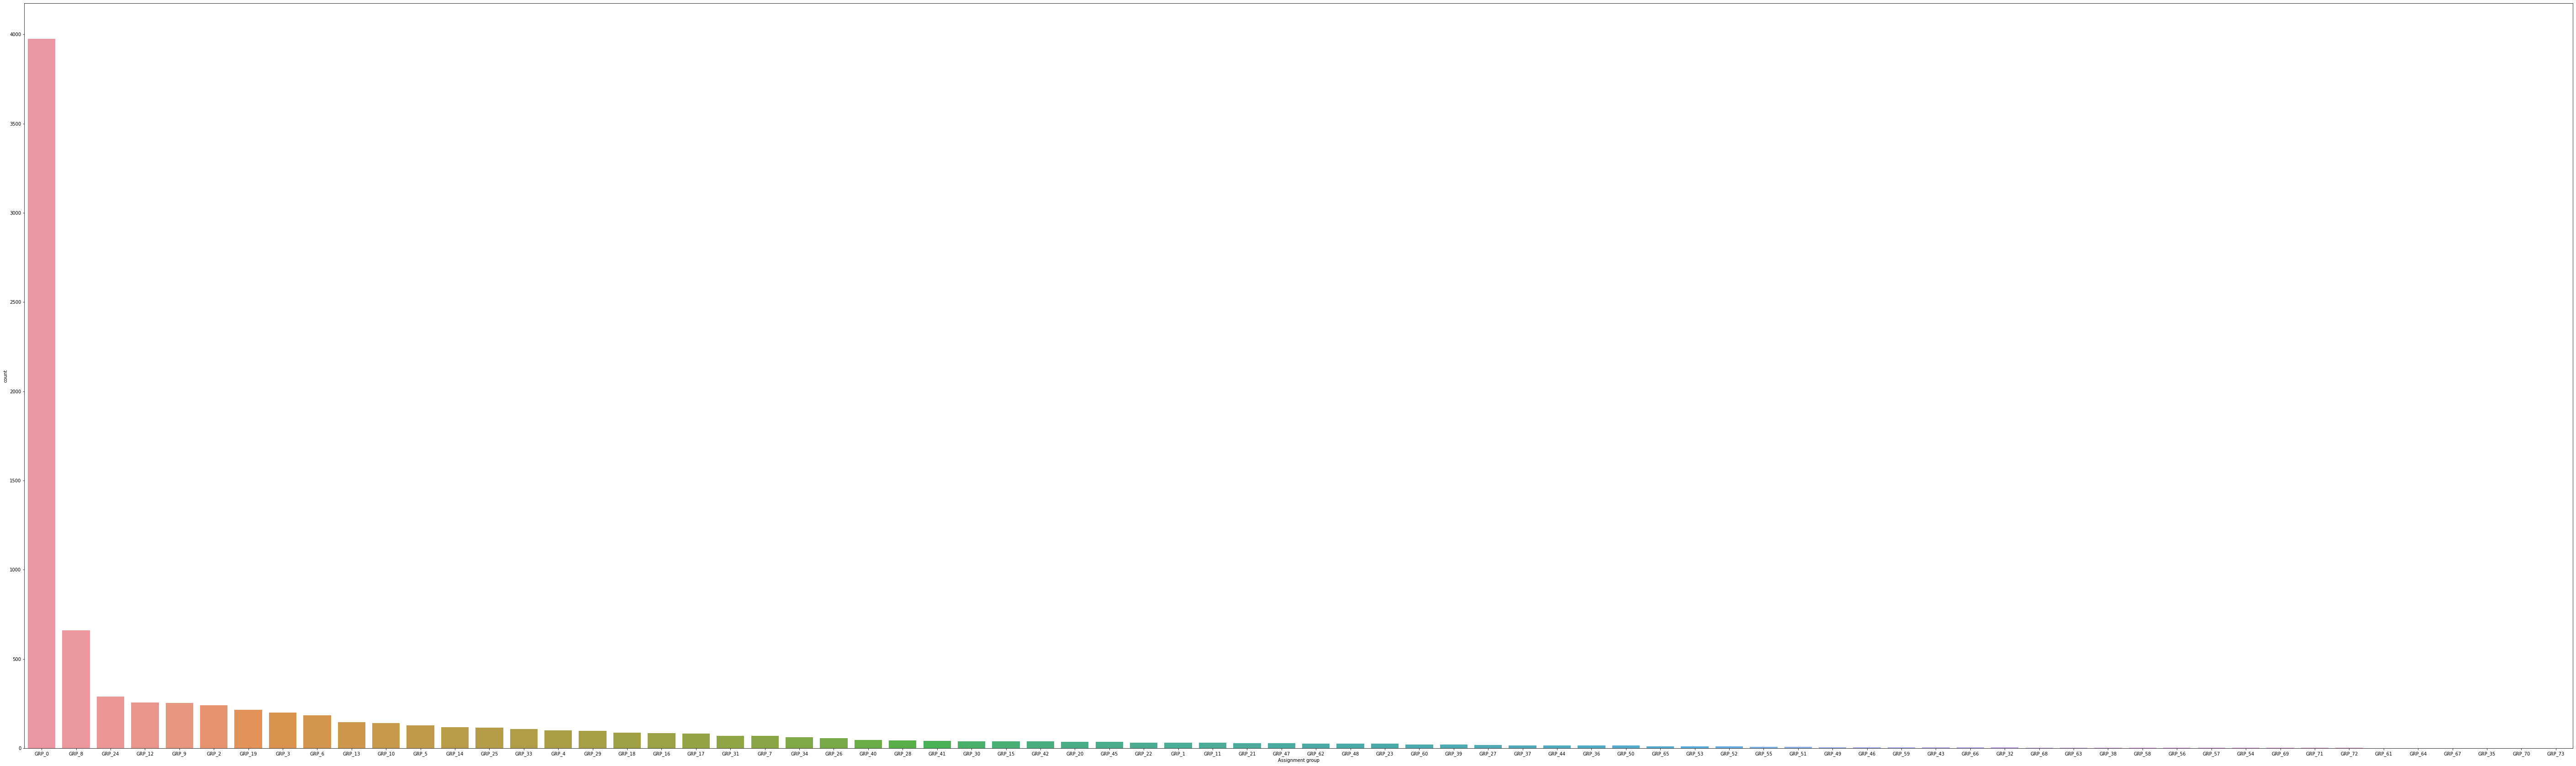

In [8]:
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(100, 30))
# Count plot for Assignment group 
sns.countplot(x='Assignment group',data=df_data, order=df_data['Assignment group'].value_counts().index, ax=ax)
plt.show()

**Number of assignment group - 74 and High Target imbalance**

** Need to clarify ** how do we create train & test data, many classes has only 1 samples, should we make sure that all classes have samples in Train data ?

In [9]:
# Number of users
print(df_data['Caller'].value_counts())
print('\nNumber of users ', len(df_data['Caller'].value_counts()))

bpctwhsn kzqsbmtp    810
ZkBogxib QsEJzdZO    151
fumkcsji sarmtlhy    134
rbozivdq gmlhrtvp     87
rkupnshb gsmzfojw     71
                    ... 
lfcwmxap ehodblur      1
lszhkxoy blemoyjd      1
dnjxilqu povreyhq      1
eyoqnkjl gakhdebf      1
kqvbrspl jyzoklfx      1
Name: Caller, Length: 2950, dtype: int64

Number of users  2950


● Dealing with missing values

In [10]:
# Get unique values for each feature value along with Null check, find category values
# Show_levels - if True provide details of unique values 
def summarize_features(df, show_levels=False):
    """
        Display uniqueness in each column
    """
    data = [[c,df[c].unique(), len(df[c].unique()), df[c].isnull().sum()] for c in df.columns]
    df_temp = pd.DataFrame(data, index=df.columns,
                           columns=['Column','No. of Unique values', 'uniq_val_count', 'No. of Missing Values'])
    return df_temp.iloc[:, 0 if show_levels else 1:]

df_summarize_features = summarize_features(df_data,True)
df_summarize_features

,Column,No. of Unique values,uniq_val_count,No. of Missing Values
Short description,Short description,"[login issue, outlook, cant log in to vpn, una...",7482,8
Description,Description,[-verified user details.(employee# & manager n...,7818,1
Caller,Caller,"[spxjnwir pjlcoqds, hmjdrvpb komuaywn, eylqgod...",2950,0
Assignment group,Assignment group,"[GRP_0, GRP_1, GRP_3, GRP_4, GRP_5, GRP_6, GRP...",74,0


**Number of missing values is less, but need to do text processing and check if there are any empty descriptions after cleaning up words (data pre-processing)**

In [11]:
# missing value treatment 
cond1 = df_data['Short description'].isnull()
cond2 = df_data['Description'].isnull()
df_missing = df_data[ cond1 | cond2 ]
df_missing

,Short description,Description,Caller,Assignment group
2604,NaN,_x000D_\n_x000D_\nreceived from: ohdrnswl.rezu...,ohdrnswl rezuibdt,GRP_34
3383,NaN,_x000D_\n-connected to the user system using t...,qftpazns fxpnytmk,GRP_0
3906,NaN,-user unable tologin to vpn._x000D_\n-connect...,awpcmsey ctdiuqwe,GRP_0
3910,NaN,-user unable tologin to vpn._x000D_\n-connect...,rhwsmefo tvphyura,GRP_0
3915,NaN,-user unable tologin to vpn._x000D_\n-connect...,hxripljo efzounig,GRP_0
3921,NaN,-user unable tologin to vpn._x000D_\n-connect...,cziadygo veiosxby,GRP_0
3924,NaN,name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...,wvqgbdhm fwchqjor,GRP_0
4341,NaN,_x000D_\n_x000D_\nreceived from: eqmuniov.ehxk...,eqmuniov ehxkcbgj,GRP_0
4395,i am locked out of skype,NaN,viyglzfo ajtfzpkb,GRP_0


In [12]:
#Check in missing value , how many records are available for that group in entire dataset
df_data[df_data['Assignment group'].isin(df_missing['Assignment group'].unique())]['Assignment group'].value_counts()


GRP_0     3976
GRP_34      62
Name: Assignment group, dtype: int64

In [13]:
#Check in missing value , how many caller records are available for that caller in entire dataset
df_data[df_data['Caller'].isin(df_missing['Caller'].unique())]['Caller'].value_counts()


qftpazns fxpnytmk    12
wvqgbdhm fwchqjor     8
rhwsmefo tvphyura     7
ohdrnswl rezuibdt     6
awpcmsey ctdiuqwe     4
viyglzfo ajtfzpkb     3
cziadygo veiosxby     2
hxripljo efzounig     1
eqmuniov ehxkcbgj     1
Name: Caller, dtype: int64

In [14]:
df_data['Short description']

0                                             login issue
1                                                 outlook
2                                      cant log in to vpn
3                           unable to access hr_tool page
4                                            skype error 
                              ...                        
8495                    emails not coming in from zz mail
8496                             telephony_software issue
8497    vip2: windows password reset for tifpdchb pedx...
8498                       machine nÃ£o estÃ¡ funcionando
8499    an mehreren pc`s lassen sich verschiedene prgr...
Name: Short description, Length: 8500, dtype: object

In [15]:
df_data['Description']

0       -verified user details.(employee# & manager na...
1       _x000D_\n_x000D_\nreceived from: hmjdrvpb.komu...
2       _x000D_\n_x000D_\nreceived from: eylqgodm.ybqk...
3                           unable to access hr_tool page
4                                            skype error 
                              ...                        
8495    _x000D_\n_x000D_\nreceived from: avglmrts.vhqm...
8496                             telephony_software issue
8497    vip2: windows password reset for tifpdchb pedx...
8498    i am unable to access the machine utilities to...
8499    an mehreren pc`s lassen sich verschiedene prgr...
Name: Description, Length: 8500, dtype: object

In [16]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


In [17]:
import re

def preprocess_text(df_column):
  # convert column to string
  df_column=df_column.apply(str)
  # Select only alphabets
  df_column = df_column.apply(lambda x: re.sub('[^A-Za-z]+', ' ', x))
  # Convert text to lowercase
  df_column = df_column.apply(lambda x: x.lower())
  # Strip unwanted spaces
  df_column = df_column.apply(lambda x: x.strip())

  return df_column

#Apply pre process function on Short decription  & Description column
df_data['Short description'] = preprocess_text(df_data['Short description'])
df_data['Description'] = preprocess_text(df_data['Description'])

In [18]:
# Import stop words list from NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords # Import stop words

stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Word Cloud for Description & Short description

In [19]:
from wordcloud import WordCloud

def wordplot(dataset, color = 'white'):
  words = ' '.join(dataset)
  cleaned_words = ' '
  #if any common words needs to be filtered can be included here in the if clause
  cleaned_words = ' '.join( [word for word in words.split () if (word != 'Hello' and word != 'error' and word != 'company') ])
  wordcloud = WordCloud(stopwords = stop_words,
                        max_words=100,
                        background_color = color,
                        scale=3,
                        width = 2500, height = 2500).generate(cleaned_words)
  plt.figure(1, figsize = (10,10))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

Description - Word cloud


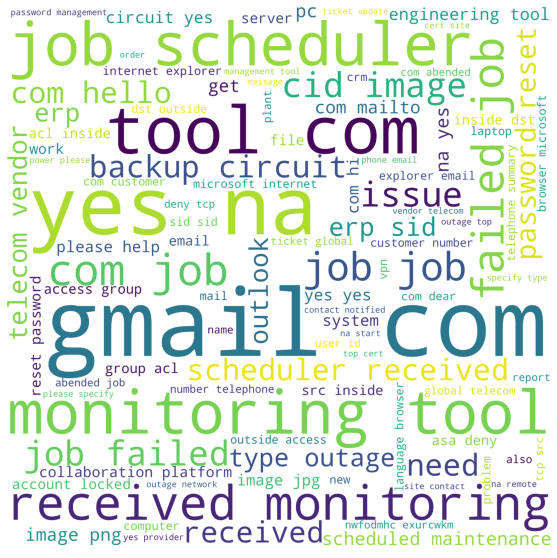

In [20]:
print("Description - Word cloud")
wordplot(df_data['Description'], 'white')

Short Description - Word cloud


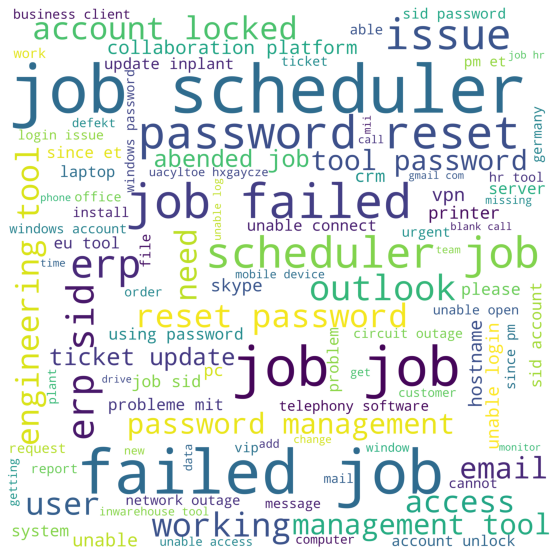

In [21]:
print("Short Description - Word cloud")
wordplot(df_data['Short description'], 'white')

**Both Short Description and Description has similar words, but there are bunch of words addition in both fields, it would be good idea to use both features for ticket classification**

#### Length of each ticket description 

In [22]:
print("Max length of each ticket description", df_data['Description'].str.len().max())
print("Min length of each ticket description", df_data['Description'].str.len().min()) 
print("Mean length of each ticket description", round(df_data['Description'].str.len().mean(),2)) 

Max length of each ticket description 8022
Min length of each ticket description 0
Mean length of each ticket description 175.06


In [23]:
print("Max length of each ticket short description", df_data['Short description'].str.len().max())
print("Min length of each ticket short description", df_data['Short description'].str.len().min()) 
print("Mean length of each ticket short description", round(df_data['Short description'].str.len().mean(),2)) 

Max length of each ticket short description 156
Min length of each ticket short description 0
Mean length of each ticket short description 40.85


In [24]:
# Sample tickets with no descriptions
df_data[df_data['Description'].str.len() == 0].head(10)

,Short description,Description,Caller,Assignment group
1081,,,bwstnmjh yqumwrsk,GRP_48
1178,,,cyjlqdwm kywiuosn,GRP_30
1452,,,spgdcvhb ocagnpmj,GRP_30
1700,,,neovalui kabpfvic,GRP_48
1701,,,ofiglcaq hvcqtzel,GRP_48
1704,,,yvscpgax wdfxytzu,GRP_48
1711,,,ofiglcaq hvcqtzel,GRP_48
1954,,,xjvubmlq vyamhjip,GRP_30
1955,,,qsfcxzel quwykhno,GRP_30
2004,,,weqocbnu eoixcpvy,GRP_31


In [25]:
# Sample tickets with no short descriptions
df_data[df_data['Short description'].str.len() == 0].head(10)

,Short description,Description,Caller,Assignment group
1081,,,bwstnmjh yqumwrsk,GRP_48
1178,,,cyjlqdwm kywiuosn,GRP_30
1452,,,spgdcvhb ocagnpmj,GRP_30
1568,,x d crm vpn ethics x d x d x d x d,tmufgokq qtzavows,GRP_31
1700,,,neovalui kabpfvic,GRP_48
1701,,,ofiglcaq hvcqtzel,GRP_48
1704,,,yvscpgax wdfxytzu,GRP_48
1710,,st p,tvykmlex hcawjigf,GRP_48
1711,,,ofiglcaq hvcqtzel,GRP_48
1954,,,xjvubmlq vyamhjip,GRP_30


In [26]:
cond1 = df_data['Description'].str.len() == 0 
cond2 = df_data['Short description'].str.len() == 0 

print("Description empty ", len(df_data[cond1]))
print("Short Description empty ", len(df_data[cond2]))

df_missing_all = df_data[ cond1 & cond2 ]
print("Both description empty " , len(df_missing_all)  )
df_missing_any_one = df_data[ cond1 | cond2 ]
print("Any one description empty " , len(df_missing_any_one)  )


Description empty  35
Short Description empty  48
Both description empty  33
Any one description empty  50


few rows doesnt have both Description and Short description if data pre processing is done. Need to deal with these missing values. Also need to check this again after applying stop words removal ** Need to clarify ** 

In [27]:
# Missing value count at each assignment group level
df_missing_all['Assignment group'].value_counts()

GRP_48    16
GRP_30    14
GRP_31     3
Name: Assignment group, dtype: int64

In [28]:
#Check in missing value , how many records are available for that group in entire dataset
df_data[df_data['Assignment group'].isin(df_missing_all['Assignment group'].unique())]['Assignment group'].value_counts()

GRP_31    69
GRP_30    39
GRP_48    25
Name: Assignment group, dtype: int64

In [29]:
# Total number of words / unique words in dataset 
all_words = ''
for words in df_data['Description'] :
  all_words += ' '.join([word for word in words.split()])
print("Total Number of words in Description" , len(all_words.split()))
all_words_unique = set(all_words.split())
print("Vocabulary Size - Total Number of unique words in Description" ,len(all_words_unique))

Total Number of words in Description 279937
Vocabulary Size - Total Number of unique words in Description 19343


**Merging both Description and Short description**

In [30]:
df_data['Desc_All'] = df_data['Short description'] + ' '+ df_data['Description']
# Strip unwanted spaces
df_data['Desc_All'] = df_data['Desc_All'].apply(lambda x: x.strip())

**Analyzing text statistics after merging both description columns**

sentence length analysis ?? 

In [31]:
print("Max length of ticket description", df_data['Desc_All'].str.len().max())
print("Min length of ticket description", df_data['Desc_All'].str.len().min()) 
print("Mean length of ticket description", round(df_data['Desc_All'].str.len().mean(),2)) 
print("Median length of ticket description", round(df_data['Desc_All'].str.len().median(),2)) 
print("Mode length of ticket description", round(df_data['Desc_All'].str.len().mode(),2)) 

Max length of ticket description 8093
Min length of ticket description 0
Mean length of ticket description 216.9
Median length of ticket description 132.0
Mode length of ticket description 0    119
dtype: int64


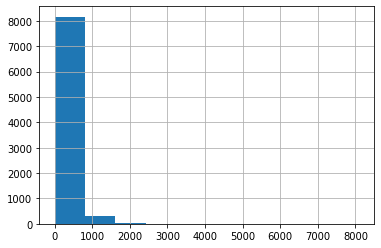

In [32]:
df_data['Desc_All'].str.len().hist()

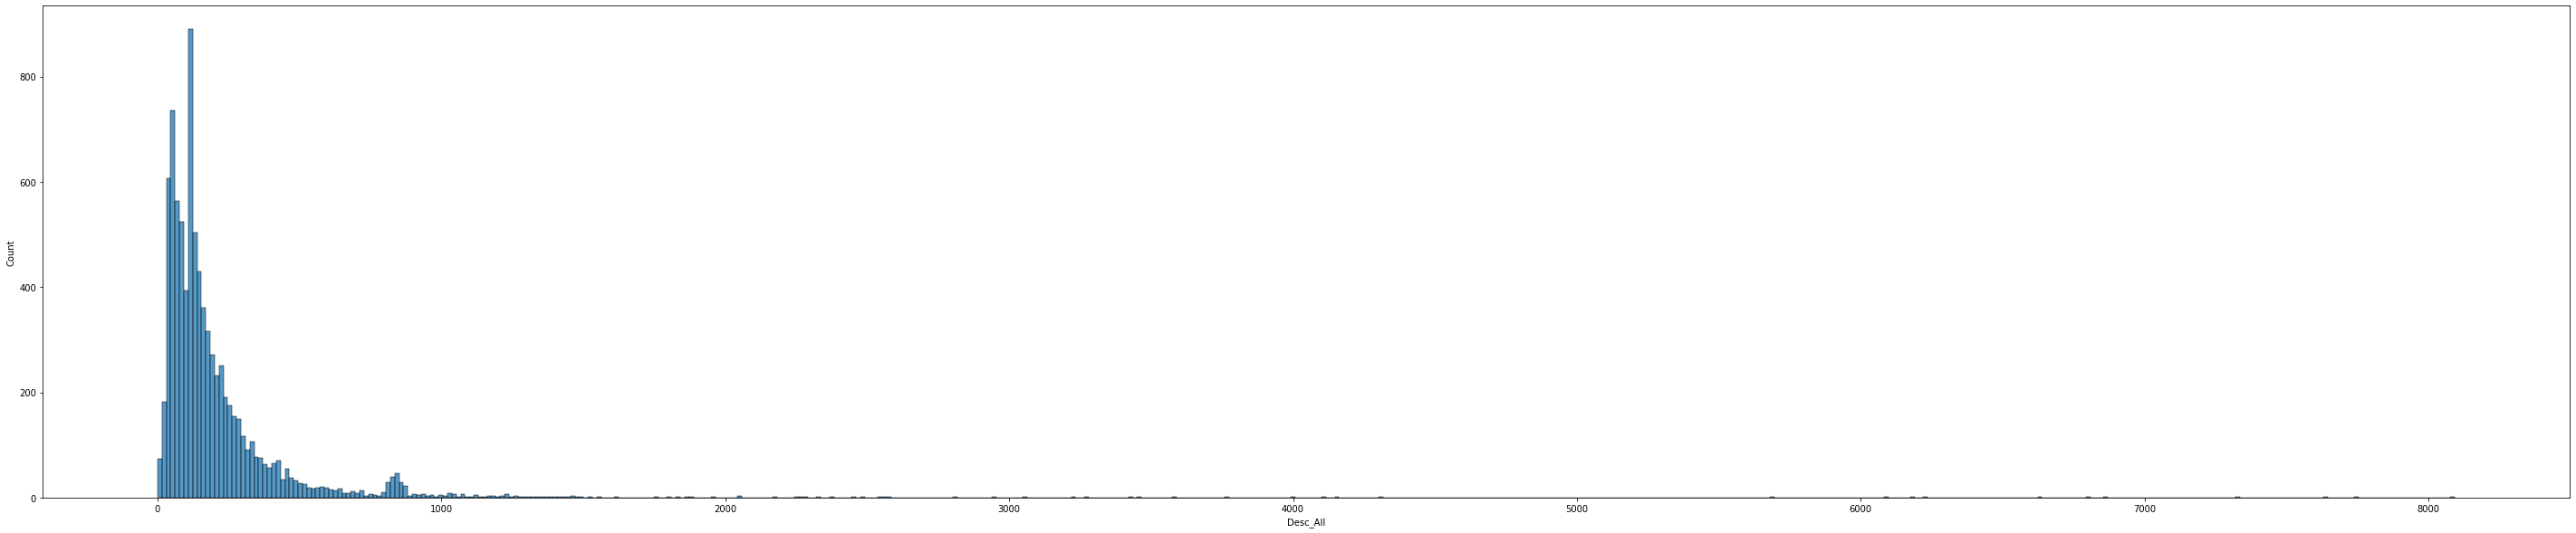

In [33]:
fig2, ax2 = plt.subplots(figsize=(50, 10))
sns.histplot(df_data['Desc_All'].str.len(), ax=ax2)
plt.show()

The histogram shows that description range from 0 to 6780 characters and generally, it is between 0 to 250 characters.

word frequency analysis ??

Number of characters present in each ticket description

In [34]:
# No of words in each ticket descriptions
max_words = df_data['Desc_All'].apply(lambda x: len(x.split())).max()
min_words = df_data['Desc_All'].apply(lambda x: len(x.split())).min()
mean_words = df_data['Desc_All'].apply(lambda x: len(x.split())).mean()

print("Max words in a ticket description ", max_words)
print("Min words in a ticket description", min_words)

print("Avearage words in a ticket description", mean_words)

Max words in a ticket description  2067
Min words in a ticket description 0
Avearage words in a ticket description 40.950823529411764


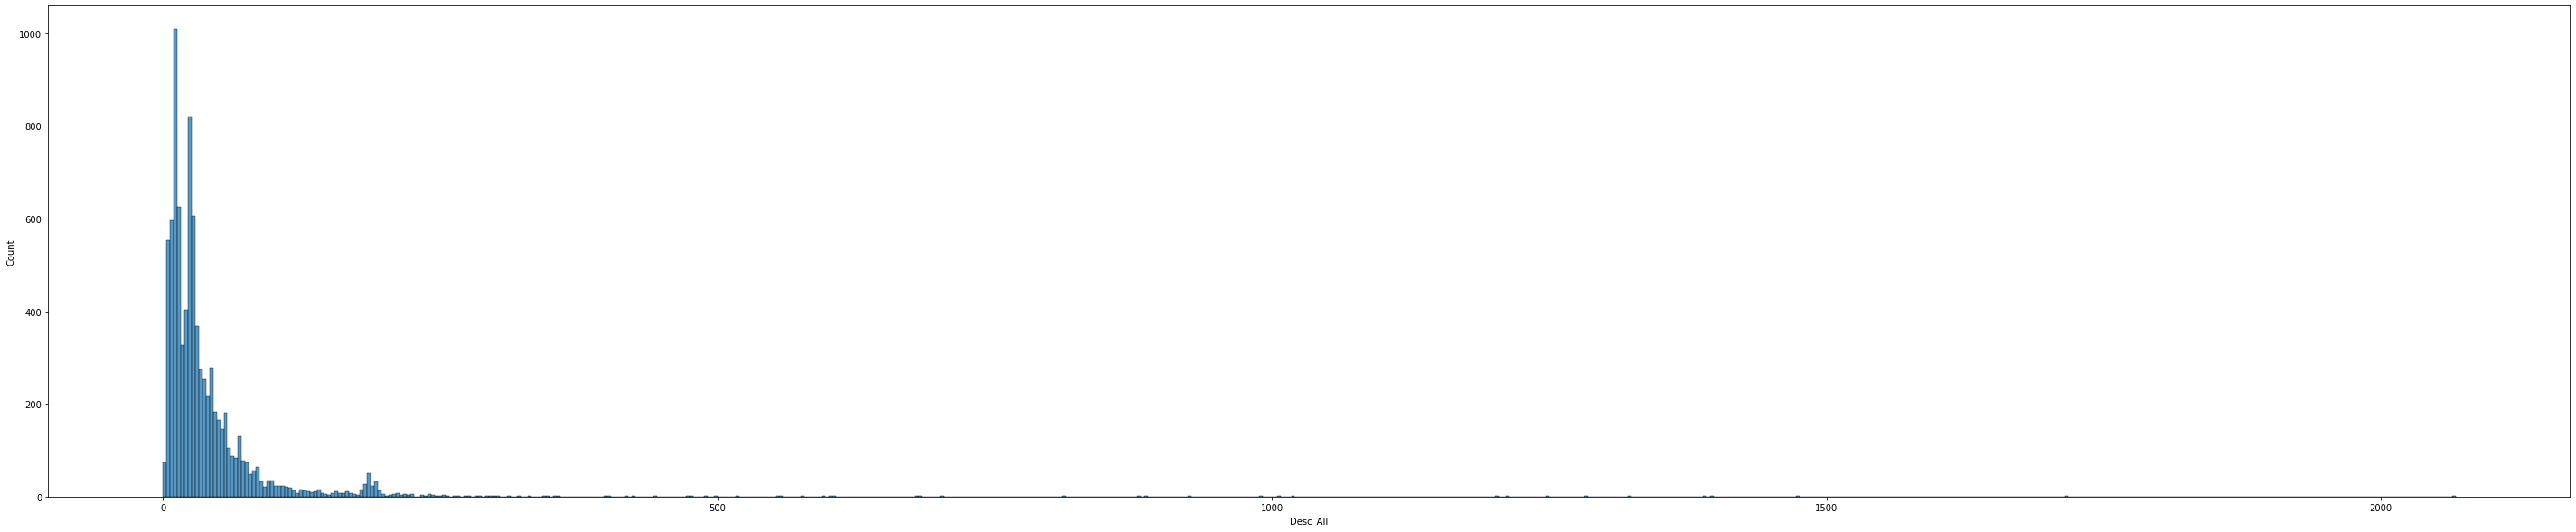

In [35]:
fig3, ax3 = plt.subplots(figsize=(50, 10))
sns.histplot(df_data['Desc_All'].apply(lambda x: len(x.split())), ax = ax3)
plt.show()

Number of words ranges from 0 till 1504.

Mostly we have 5 to 50 words in each tickets.

In [50]:
# Total number of words / unique words in dataset 
all_words = ''
for words in df_data['Desc_All'] :
  all_words += ' '.join([word for word in words.split()])
print(all_words)
print("Total Number of words in Description" , len(all_words.split()))
all_words_unique = set(all_words.split())
print("Vocabulary Size - Total Number of unique words in Description" ,len(all_words_unique))

login issue verified user details employee manager name x d checked the user name in ad and reset the password x d advised the user to login and check x d caller confirmed that he was able to login x d issue resolvedoutlook x d x d received from hmjdrvpb komuaywn gmail com x d x d hello team x d x d my meetings skype meetings etc are not appearing in my outlook calendar can somebody please advise how to correct this x d x d kindcant log in to vpn x d x d received from eylqgodm ybqkwiam gmail com x d x d hi x d x d i cannot log on to vpn x d x d bestunable to access hr tool page unable to access hr tool pageskype error skype errorunable to log in to engineering tool and skype unable to log in to engineering tool and skypeevent critical hostname company com the value of mountpoint threshold for oracle sid erpdata event critical hostname company com the value of mountpoint threshold for oracle sid erpdata sr psa d sr psa d data perpsr psa d isticket no employment status new non employee e

**Build Corpus**

In [ ]:
corpus=[]
# Series object 
tickets= df_data['Desc_All'].str.split()
tickets_list=tickets.values.tolist()
corpus=[word for ticket in tickets_list for word in ticket]
#print(corpus)
print('corpus word count', len(corpus))
corpus_uniq_words = set(word for word in corpus)
print('unique words count',len(corpus_uniq_words) )

**Stop word analysis**

corpus word count 348082
unique words count 15378


<BarContainer object of 10 artists>

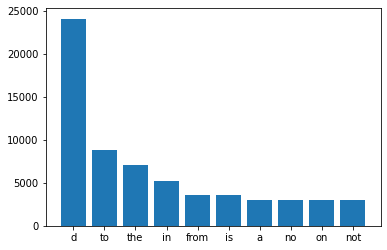

In [59]:


from collections import defaultdict
dic_stop_words=defaultdict(int)
for word in corpus:
    if word in stop_words:
        dic_stop_words[word]+=1

top=sorted(dic_stop_words.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)


('x', 'job', 'com', 'company', 'tool', 'received', 'password', 'gmail', 'please', 'erp')
(23450, 5060, 3804, 2791, 2753, 2387, 2383, 2205, 2183, 2099)


<BarContainer object of 10 artists>

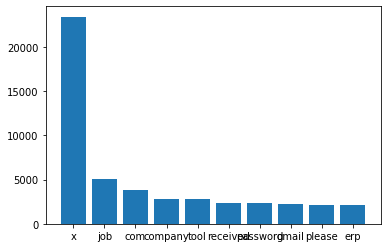

In [75]:


dic_non_stop_words=defaultdict(int)
for word in corpus:
    if word not in stop_words:
        dic_non_stop_words[word]+=1

top=sorted(dic_non_stop_words.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)

print(x)
print(y)

plt.bar(x,y)


Top Non Stop words


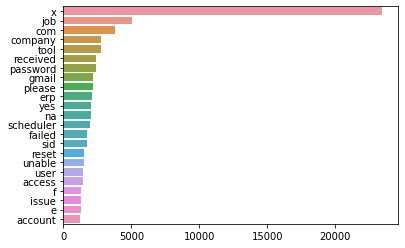

In [83]:
print("Top Non Stop words")
from collections import  Counter
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in stop_words):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)


Need to check words x, f, e 

**Ngram exploration**

Ngrams are simply contiguous sequences of n words. For example “riverbank”,” The three musketeers” etc.If the number of words is two, it is called bigram. For 3 words it is called a trigram and so on.

Looking at most frequent n-grams can give you a better understanding of the context in which the word was used.

In [89]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

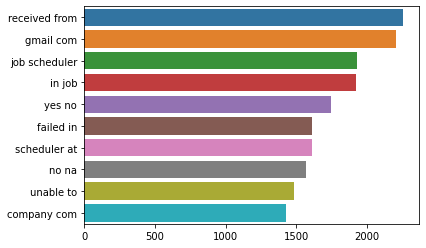

In [90]:
n=2 # bigram 
plot_top_ngrams_barchart(df_data['Desc_All'],n)

'job scheduler', 'job', 'failed in' , 'unable to', 'gmail com' indicating issues in Jobs and also unable to access gmail com 

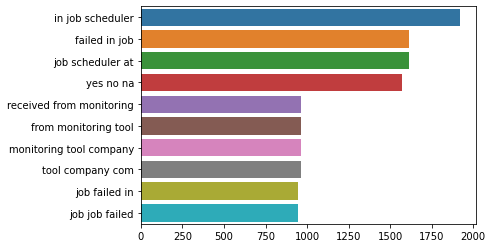

In [92]:
n=3 # trigram
plot_top_ngrams_barchart(df_data['Desc_All'],n)

Repeated combinations for group of words ' Job scheduler at' , 'from monitoring tool', ' job failed in ' 

**Topic modeling exploration with pyLDAvis**

Topic modeling is the process of using unsupervised learning techniques to extract the main topics that occur in a collection of documents.

Latent Dirichlet Allocation (LDA) is an easy to use and efficient model for topic modeling. Each document is represented by the distribution of topics and each topic is represented by the distribution of words.

In [93]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 23.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=e05abd1f5384f6128e44c6a04cd39b245c2bff3d66303aed96fa7756c0842286
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [96]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [99]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [102]:
import warnings
warnings.filterwarnings(action= 'ignore')

In [109]:
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim_models

num_topics = 10

def get_lda_objects(text):
    nltk.download('stopwords')    
    stop=set(stopwords.words('english'))

    
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = num_topics, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
    #.gensim.prepare(lda_model, bow_corpus, dic)
    return vis

In [110]:
lda_model, bow_corpus, dic = get_lda_objects(df_data['Desc_All'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [111]:
lda_model.show_topics()

[(0,
  '0.021*"error" + 0.016*"please" + 0.014*"com" + 0.013*"image" + 0.013*"cid" + 0.013*"gmail" + 0.012*"collaboration" + 0.012*"platform" + 0.012*"received" + 0.010*"message"'),
 (1,
  '0.145*"password" + 0.083*"reset" + 0.032*"erp" + 0.031*"tool" + 0.021*"management" + 0.017*"sid" + 0.015*"window" + 0.014*"please" + 0.012*"user" + 0.011*"request"'),
 (2,
  '0.034*"tool" + 0.020*"gmail" + 0.019*"com" + 0.017*"email" + 0.017*"issue" + 0.016*"engineering" + 0.014*"please" + 0.013*"unable" + 0.012*"number" + 0.012*"error"'),
 (3,
  '0.060*"account" + 0.037*"erp" + 0.033*"locked" + 0.020*"sid" + 0.016*"unlock" + 0.014*"mit" + 0.014*"com" + 0.013*"nicht" + 0.012*"gmail" + 0.010*"ethic"'),
 (4,
  '0.086*"yes" + 0.033*"site" + 0.030*"circuit" + 0.027*"power" + 0.024*"vendor" + 0.022*"network" + 0.022*"backup" + 0.021*"telecom" + 0.020*"company" + 0.020*"outage"'),
 (5,
  '0.039*"hostname" + 0.022*"update" + 0.021*"ticket" + 0.019*"server" + 0.015*"order" + 0.014*"usa" + 0.014*"plant" + 0.

In [112]:
plot_lda_vis(lda_model, bow_corpus, dic)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.094842  0.015339       1        1  14.401887
4      0.070633 -0.357752       2        1  11.484273
2     -0.101745  0.064296       3        1  11.308576
8      0.382662  0.071296       4        1  10.740552
5     -0.053468 -0.040637       5        1   9.761808
6     -0.064401 -0.106846       6        1   9.672547
9     -0.069498  0.007941       7        1   9.439691
3      0.082398  0.136026       8        1   7.998143
1     -0.043705  0.139855       9        1   7.825360
7     -0.108033  0.070482      10        1   7.367163, topic_info=          Term         Freq        Total Category  logprob  loglift
198        job  4270.000000  4270.000000  Default  30.0000  30.0000
12    password  2262.000000  2262.000000  Default  29.0000  29.0000
348        yes  1956.000000  1956.000000  Default  28.0000  28.0000
225  scheduler  1622.000000  1622.000000  Default  27.0000  27.0000
13       reset  1431.000000  1431.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
228     window   104.254617   596.538393  Topic10  -4.9312   0.8638
117        crm    88.517167   408.826641  Topic10  -5.0949   1.0780
99     working    90.461849   770.587061  Topic10  -5.0731   0.4659
832      ethic    70.898269   253.457789  Topic10  -5.3168   1.3342
45       error    70.146527  1078.713396  Topic10  -5.3275  -0.1248

[701 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
10799      4  0.998701       abended
0          1  0.180836          able
0          3  0.194927          able
0          5  0.046970          able
0          6  0.011743          able
...      ...       ...           ...
361        6  0.968735      yhmwxsqj
13828      9  0.950525          zdis
10401      8  0.957685      zdsxmcwu
1098       8  0.951345           zur
3966       3  0.957006  zuteillisten

[1660 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 9, 6, 7, 10, 4, 2, 8])

● Text preprocessing
include lemmatization

In [39]:


def remove_stopwords(df_column):
  # Remove stop words
  df_column  = df_column.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

  return df_column



● Creating word vocabulary from the corpus of report text data

● Creating tokens as required

Interim Delivery checklist

1. Summary of problem statement, data and findings
Every good abstract describes briefly what was intended at the outset, and summarizes findings and implications.

2. Summary of the Approach to EDA and Pre-processing
Include any insightful visualization you have teased out of the data. If you’ve identified particularly meaningful features, interactions or summary data, share them and explain what you noticed. Visual displays are powerful when used well, so think carefully about what information the display conveys.

3. Deciding Models and Model Building
Based on the nature of the problem, decide what algorithms will be suitable and why?
Experiment with different algorithms and get the performance of each algorithm.

4. How to improve your model performance?
What are the approaches you can take to improve your model? Can you do some feature selection, data manipulation and model improvements.


Which Embedding to be used - Bag of words, TF-IDF , Word2vec, Glove Embedding?


Models to be tried ? ML classifier, LSTM, State of Art  - BERT, XLNet 

Interim report format if any?

# Summary of problem statement, data and findings 

Every good abstract describes briefly what was intended at the outset, and summarizes findings and implications.

Corpus has 8500 tickets created by various Business and IT Users, End Users/ Vendors through ticketing system

The corpus had  over <>  words - or approximately <>  and <> words per person. 

Each ticket has 
1.   Short Description - Short description about ticket
2.   Description - Problem explained in detail by user
3.   Caller - User for whom ticket is created
4.   Assignment group - IT group to which ticket needs to be assigned 


Each blog in the corpus includes at least <> occurrences of common English words. All formatting has been stripped ? any  exceptions like links within a post are denoted by the label url link. 